The following work is produced by Jo Pan for CIS5516 Machine Learning final project. <br/>
# 1. Twitter Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import demoji

import nltk, unicodedata, re #import nltk, re, string, collections, unicodedata
from wordcloud import WordCloud, STOPWORDS

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
### Run the followings if running for the first time
#demoji.download_codes()
#nltk.download('stopwords')
#nltk.download('vader_lexicon')
#nltk.download('words')

## 1.1 Twitter Scraping

In [2]:
import snscrape.modules.twitter as sntwitter
import csv, os

In [3]:
# When run for the first time, add title row.
if not os.path.exists("place_result.csv"):
    csvFile = open('place_result.csv', 'a', newline='', encoding='utf8')
    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(['id','date','tweet'])

# Search by location Los Angeles (Hot place for BYND in Google Trend)
#request = 'geocode:34.081715,-118.248838,15mi + since:2020-10-31 until:2020-11-15 -filter:links -filter:replies'

# Search by keyword
keyword = 'beyond meat' #'beyondmeat'
request = keyword + ' + since:2020-01-01 until:2020-12-12 -filter:links -filter:replies'

for run in range(1):
    oldcsv = np.unique(pd.read_csv('place_result.csv')['tweet'])
    
    # Open/create a file to append data to
    csvFile = open('place_result.csv', 'a', newline='', encoding='utf8')
    csvWriter = csv.writer(csvFile)
    
    new = 0
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(request).get_items()):      
            # Check if it is new tweets
            if tweet.content not in oldcsv:
                csvWriter.writerow([tweet.id, tweet.date, tweet.content])
                new +=1
            
            # Progress checking
            if i % 1000 == 0: 
                print(f'run{run}, i={i}, new={new}', tweet.date)
                
    print(f'run{run}, i={i}, new={new}', tweet.date)
    csvFile.close()

run0, i=0, new=1 2020-12-11 14:54:53+00:00
run0, i=1000, new=987 2020-11-19 20:52:18+00:00
run0, i=2000, new=1173 2020-11-10 12:03:44+00:00
run0, i=3000, new=1188 2020-10-18 15:57:19+00:00
run0, i=4000, new=1201 2020-09-22 14:15:07+00:00
run0, i=5000, new=1219 2020-08-28 00:08:08+00:00
run0, i=6000, new=1232 2020-08-04 07:38:46+00:00
run0, i=7000, new=1241 2020-07-12 00:03:46+00:00
run0, i=8000, new=1255 2020-06-21 21:28:30+00:00
run0, i=9000, new=1278 2020-05-25 17:13:04+00:00
run0, i=10000, new=1286 2020-09-03 18:26:48+00:00
run0, i=11000, new=1297 2020-04-21 03:58:11+00:00
run0, i=12000, new=1310 2020-03-18 10:56:02+00:00
run0, i=13000, new=1324 2020-02-26 17:55:08+00:00
run0, i=14000, new=1336 2020-02-06 05:40:11+00:00
run0, i=15000, new=1349 2020-01-23 14:46:15+00:00
run0, i=16000, new=1362 2020-01-10 16:17:08+00:00
run0, i=16676, new=1365 2020-01-01 01:10:42+00:00


## 1.2 Data Preprocessing
### 1.2.1 Row-level data cleaning

In [4]:
df = pd.read_csv('place_result.csv')
print('original df shape:', df.shape)

# Remove the additional title rows ['id', 'date', 'tweet']
df = df[df['id'] != 'id']

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)
print(f'Available tweets date range from: {np.min(df["date"])} to {np.max(df["date"])}')

print('current df shape: ', df.shape)
df.head()

original df shape: (50208, 3)
Available tweets date range from: 2019-07-04 00:03:50+00:00 to 2020-12-11 14:54:53+00:00
current df shape:  (17106, 3)


,id,date,tweet
0,1327760258379476995,2020-11-14 23:48:08+00:00,What’s the point of beyond meat on a regular c...
1,1321866322247036930,2020-10-29 17:27:44+00:00,Feelings of isolation during #COVID19 are prev...
2,1327759212437512192,2020-11-14 23:43:59+00:00,I have used Beyond meat for making my mom's re...
3,1327753655425097729,2020-11-14 23:21:54+00:00,beyond meat nachos for dinner &gt;&gt;&gt;&gt;
4,1327752883442511882,2020-11-14 23:18:50+00:00,i tried to type beyond meat and it autocorrect...


### 1.2.2 New column: quarter and month

In [5]:
# convert date to quarter. The dates used for spliting are the same as Yahoo Finance
df['quarter'] = 0
dates = ['2020-03-31', '2020-06-30', '2020-09-30']

df.loc[df['date'] < dates[0], 'quarter'] = 1
df.loc[(df['date'] > dates[0]) & (df['date'] < dates[1]), 'quarter'] = 2
df.loc[(df['date'] > dates[1]) & (df['date'] < dates[2]), 'quarter'] = 3
df.loc[df['date'] > dates[2], 'quarter'] = 4
print('quarter', np.unique(df['quarter'], return_counts=True))

# convert date to month
df['month'] = pd.DatetimeIndex(df.date).month
print('month', np.unique(df['month'], return_counts=True))

quarter (array([1, 2, 3, 4]), array([5125, 4138, 4013, 3830]))
month (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([2369, 1600, 1181, 1157, 1779, 1223, 1426, 1354, 1227, 1156, 2208,
        426]))


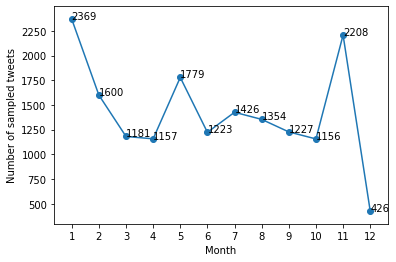

In [7]:
m, c = np.unique(df['month'], return_counts=True)
plt.plot(m, c)
plt.scatter(m,c)
#_ = plt.title('Number of sampled tweets each month')
_ = plt.xticks(np.arange(1, 13, 1))
for i, txt in enumerate(c):
    plt.annotate(txt, (i+1, c[i]))
_ = plt.xlabel('Month')
_ = plt.ylabel('Number of sampled tweets')
plt.savefig('num_tweets_per_month.png')

### 1.2.3 Text cleaning

In [8]:
#tweet = "Had my first #beyondmeat Burger as a treat today. Think it's the future. Very very good. Little high in saturated fat for my liking but still mighty impressed 👏👍"
#emo = demoji.findall(tweet)
#emo

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['im', 'wheres', 'whats','whichs', 'whatr','wherer', 'wer', 'dont', 'thats']

def clean(tweet):
    # Replace emoji with text
    emo = demoji.findall(tweet)
    if len(emo) > 0:
        for emo, emo_text in emo.items():
            emo_text = emo_text.replace('face', '') # 'face' is useless for analysis, thus removing
            emo_text = emo_text.replace('nerd', '') # the emoji is actually neutral meaning
            emo_text = emo_text.replace('loudly crying', '') # confusing emoji. more than half of the time, it means touching, rather than crying.
            emo_text = emo_text.replace('savoring food', 'tasty')
            emo_text = emo_text.replace('vomiting', 'disgusting')
            emo_text = emo_text.replace('drooling', 'tasty')
            emo_text = emo_text.replace('hearteyes', 'like')
            if 'palming' in emo_text:
                emo_text = 'disappointing'
            if 'thumbs up' in emo_text:
                emo_text = 'good'
            if 'thumbs down' in emo_text:
                emo_text = 'bad'

            # 'fire' is placed at the negetive sentiment side.
            # However, most of tweets actually uses it for good.
            emo_text = emo_text.replace('fire', 'good')
            tweet = tweet.replace(emo, emo_text+' ')
    
    # Normalize text 
    tweet = (unicodedata.normalize('NFKD', tweet)
                .encode('ascii', 'ignore')
                .decode('utf-8', 'ignore')
                .lower())
    
    # Remove other useless phases
    tweet = re.sub(r'|\n|&gt;|https.+|beyondmeat|beyond meat|', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)    
    
    # Remove stopwords
    tweet = ' '.join([w for w in tweet.split() if w not in stopwords])
    return tweet

In [9]:
df['tweet2'] = df['tweet'].apply(lambda x: clean(x))
words = df['tweet2'].str.cat(sep=' ').split()
ngrams_2 = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:50]
print(len(words))

202176


## 1.3 Sentiment analysis

In [10]:
sid = SentimentIntensityAnalyzer()
def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

In [11]:
df['VADAR'] = sentiment(df['tweet2'])
df['compound']  = df['VADAR'].apply(lambda score_dict: score_dict['compound'])
df['sentiment']  = df['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))

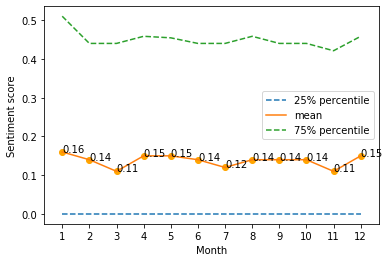

In [12]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)

f = {'compound': ['std', q1, q2]}
stats = df.groupby(['month']).agg(f).compound
mean = df.groupby(['month']).mean().compound.round(2)

plt.plot(stats.q1, label='25% percentile', linestyle='dashed')
plt.plot(mean, label='mean')
plt.scatter(np.arange(1,13,1),mean, color='orange')
plt.plot(stats.q2, label='75% percentile', linestyle='dashed')
for i, txt in enumerate(mean):
    plt.annotate(txt, (i+1, mean[i+1]))
plt.legend()
#_ = plt.title('Sentiment score over months')
_ = plt.xticks(np.arange(1, 13, 1))
_ = plt.xlabel('Month')
_ = plt.ylabel('Sentiment score')
plt.savefig('sentiment_score_per_month.png')

November's sentiment dropped significantly. However, the score is still positive. Possibly, this is caused by the increased amount of neutral tweets (sentiment score closes to zero) from the cooperation announcements with fast-food chain companies.

In [22]:
i = 1
sent_percent = []
for i in range(1, 13, 1):
    tot = len(df[(df['month']==i)])
    temp = []
    for s in ['pos', 'neu', 'neg']:
        temp.append(len(df[(df['month']==i) & (df['sentiment']==s)]) / tot)
    sent_percent.append(temp)
sent_percent = np.array(sent_percent)

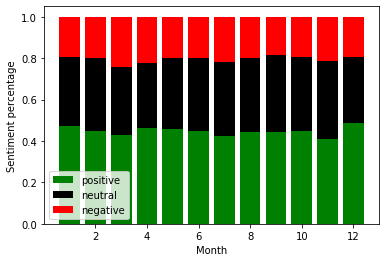

In [23]:
plt.bar(np.arange(1,13,1), sent_percent[:,0], color='green', label='positive')
plt.bar(np.arange(1,13,1), sent_percent[:,1], bottom=sent_percent[:,0], color='black', label='neutral')
plt.bar(np.arange(1,13,1), sent_percent[:,2],  bottom=sent_percent[:,0] + sent_percent[:,1], color='red', label='negative')
#plt.title('Sentiment percentage over time')
_ = plt.xlabel('Month')
_ = plt.ylabel('Sentiment percentage')
_ = plt.legend()
plt.savefig('sentiment_percentage_per_month.png')

In [15]:
stats.std

<bound method DataFrame.std of             std   q1       q2
month                        
1      0.429134  0.0  0.51060
2      0.414254  0.0  0.44040
3      0.435199  0.0  0.44040
4      0.422327  0.0  0.45880
5      0.417756  0.0  0.45485
6      0.405140  0.0  0.44040
7      0.418934  0.0  0.44040
8      0.417082  0.0  0.45880
9      0.391119  0.0  0.44040
10     0.408620  0.0  0.44040
11     0.405739  0.0  0.42150
12     0.425331  0.0  0.45880>

## 1.4 Word Cloud

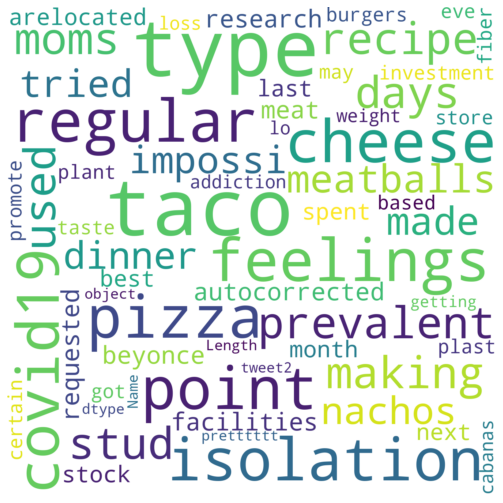

In [16]:
# All Data
plt.subplots(1, 1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(df.tweet2))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.savefig('wordcloud_all.png')

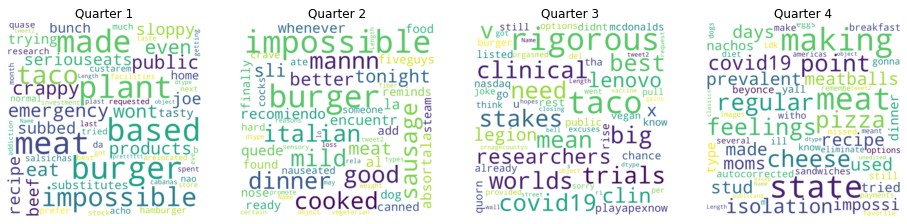

In [24]:
# Quarter by Quarter
plt.figure(figsize=(16, 8)) 
for i in range(1,5):
    plt.subplot(1, 4, i)
    wc_b = WordCloud(stopwords=STOPWORDS, 
                     background_color="white", max_words=2000,
                     max_font_size=256, random_state=42,
                     width=1600, height=1600)
    wc_b.generate(str(df[df['quarter']==i].tweet2))
    plt.imshow(wc_b, interpolation="bilinear")
    plt.title(f'Quarter {i}')
    plt.axis('off')
plt.savefig('wordcloud_quarters.png')
plt.show()

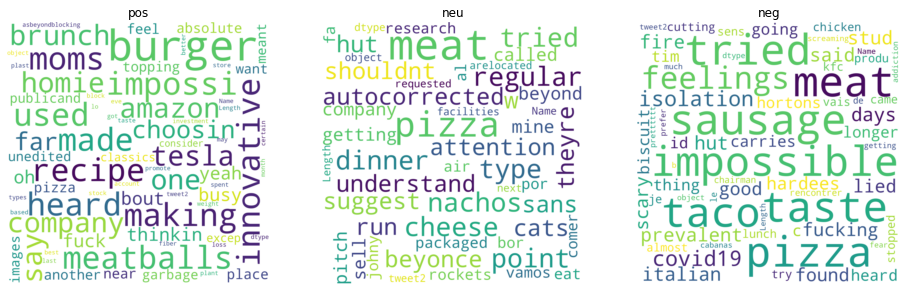

In [25]:
# Sentiment 
plt.figure(figsize=(16, 6)) 
for i in range(3):
    plt.subplot(1, 3, i+1)
    wc_b = WordCloud(stopwords=STOPWORDS, 
                     background_color="white", max_words=2000,
                     max_font_size=256, random_state=42,
                     width=1600, height=1600)
    wc_b.generate(str(df[df['sentiment']==['pos','neu','neg'][i]].tweet2))
    plt.imshow(wc_b, interpolation="bilinear")
    plt.title(['pos','neu','neg'][i])
    plt.axis('off')
plt.savefig('wordcloud_sentiment.png')
plt.show()

In [19]:
i= 10
np.array(df.loc[df['sentiment']=='neg',['tweet','tweet2']])[i: i+10]

array([['Usually Carl’s Jr. only fucks up by giving me cheese on my burger when I ask for no cheese, and mayonnaise when I ask for no mayonnaise. But today they gave me real meat when I asked for a beyond meat burger. Am sad 😢',
        'usually carls jr fucks giving cheese burger ask cheese mayonnaise ask mayonnaise today gave real meat asked burger sad crying'],
       ['Beyond meat, one of the three forbidden proteins alongside Bed meat and Bath meat',
        'one three forbidden proteins alongside bed meat bath meat'],
       ["Okay why does Beyond Meat have to put pomegranate in their meat!? \n\nI'M FUCKING DEATHLY ALLERGIC",
        'okay put pomegranate meat fucking deathly allergic'],
       ['Idk why but the beyond meat pizza hut jawn is too far',
        'idk pizza hut jawn far'],
       ['If you are eating any vegan or beyond meat products AND you experience anxiety and depression.\n\nStop falling for satan’s tricks.\n\nEat real fucking food. Vegan bs shit causes extreme in